In [1]:
from google.colab import drive
from google.colab import files
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist

%matplotlib inline

Read csv files for movies and ratings using pandas. Test out some pandas functions such as head() and len() to see if files are read correctly.

In [3]:
movies = pd.read_csv("/content/drive/My Drive/Sac State/CSC177/data/movies.csv")
ratings = pd.read_csv("/content/drive/My Drive/Sac State/CSC177/data/ratings.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
len(movies)

27278

In [7]:
len(ratings)

20000263

Find out which genre of movies are availble in the dataset.

In [8]:
genres = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()

In [9]:
genres = pd.DataFrame(genres,columns = ['genere'])
genres

,genere
0,Adventure
1,Animation
2,Children
3,Comedy
4,Fantasy
5,Romance
6,Drama
7,Action
8,Crime
9,Thriller


Merge the two datasets (movies and ratings) together using movieId.

In [10]:
ratings_genres = ratings.merge(movies, on='movieId')
ratings_genres.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


Find all unique userId from the ratings dataset.

In [11]:
userIds = ratings['userId'].unique()
userIds

array([     1,      2,      3, ..., 138491, 138492, 138493])

Filter the movies dataset to show only a specific genre.

In [12]:
horror_movies = movies[movies['genres'].str.contains('Horror')]
horror_movies

,movieId,title,genres
11,12,Dracula: Dead and Loving It (1995),Comedy|Horror
21,22,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller
69,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
90,92,Mary Reilly (1996),Drama|Horror|Thriller
91,93,Vampire in Brooklyn (1995),Comedy|Horror|Romance
...,...,...,...
27193,131015,Hellgate (2011),Horror|Thriller
27231,131112,Night of the Living Dorks (2004),Comedy|Horror
27264,131180,Dead Rising: Watchtower (2015),Action|Horror|Thriller
27272,131252,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror


Filter the ratings dataset to only show a specified genre.

In [13]:
horror_ratings = ratings[ratings['movieId'].isin(horror_movies['movieId'])]
horror_ratings

,userId,movieId,rating,timestamp
8,1,253,4.0,2005-04-02 23:35:40
17,1,593,3.5,2005-04-02 23:31:01
32,1,1200,4.0,2005-04-02 23:29:20
35,1,1214,4.0,2004-09-10 03:12:57
36,1,1215,4.0,2004-09-10 03:14:42
...,...,...,...,...
20000204,138493,34143,2.0,2009-10-17 20:30:29
20000215,138493,42738,4.5,2009-10-17 21:52:58
20000246,138493,56757,3.0,2009-10-17 20:18:18
20000247,138493,56801,3.0,2009-10-17 20:06:28


Filter the genre_ratings dataset based on whether a userId reviewed more than 49 horror movies. Thus, we can narrow down the dataset and only show the data that consist of fans of the specified genre rather than users who casually watch one or more times. 

In [14]:
user_horror_count = horror_ratings['userId'].value_counts()
horror_ratings = horror_ratings[horror_ratings.userId.isin(user_horror_count.index[user_horror_count.gt(49)])]
horror_ratings

,userId,movieId,rating,timestamp
979,11,253,4.5,2009-01-02 01:16:36
1010,11,593,5.0,2009-01-02 01:13:29
1014,11,610,4.0,2009-01-01 23:52:32
1015,11,611,3.5,2009-01-01 05:30:01
1030,11,968,5.0,2009-08-25 03:15:09
...,...,...,...,...
19999506,138486,53953,4.5,2008-04-01 18:57:12
19999507,138486,54771,4.5,2008-04-01 19:03:28
19999508,138486,55232,4.0,2008-04-01 19:04:32
19999509,138486,55282,4.5,2008-04-01 18:55:54


Get the reviewers **mean** ratings of the genre.

In [15]:
user_horror_ratings = horror_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean()
user_horror_ratings

userId
11        3.814103
54        3.485714
58        4.120482
104       2.211268
116       2.073684
            ...   
138397    3.575000
138406    3.680000
138414    3.030000
138437    3.420290
138486    4.025316
Name: rating, Length: 6053, dtype: float64

Repeating the above actions with different genres.

In [16]:
comedy_movies = movies[movies['genres'].str.contains('Comedy')]
comedy_ratings = ratings[ratings['movieId'].isin(comedy_movies['movieId'])]
user_comedy_count = comedy_ratings['userId'].value_counts()
comedy_ratings = comedy_ratings[comedy_ratings.userId.isin(user_comedy_count.index[user_comedy_count.gt(49)])]
user_comedy_ratings = comedy_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean()

Group the reviewers **mean** ratings of two seperate genres.

In [17]:
genre_ratings = pd.DataFrame(userIds, columns=["userId"])

In [18]:
genre_ratings = genre_ratings.merge(user_comedy_ratings, on="userId")
genre_ratings = genre_ratings.merge(user_horror_ratings, on="userId")
genre_ratings.columns = ['userId', 'comedy', 'horror']
genre_ratings

,userId,comedy,horror
0,11,3.748276,3.814103
1,54,3.300353,3.485714
2,58,3.917949,4.120482
3,104,2.713450,2.211268
4,116,1.948812,2.073684
...,...,...,...
5686,138397,3.738532,3.575000
5687,138406,3.763804,3.680000
5688,138414,3.253378,3.030000
5689,138437,3.615772,3.420290


Create a scatter plot of the reviewers **mean** ratings between two seperate genres.

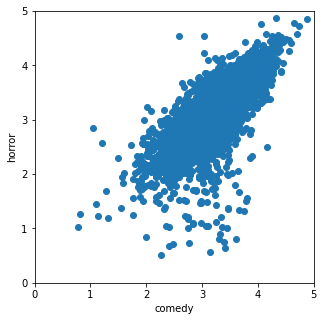

In [20]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.xlim(0,5)
plt.ylim(0,5)
ax.set_xlabel('comedy')
ax.set_ylabel('horror')
ax.scatter(genre_ratings['comedy'], genre_ratings['horror'])

Create a k-means clustering of the reviewers **mean** ratings between two seperate genres.

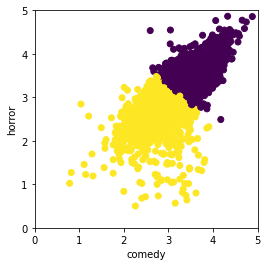

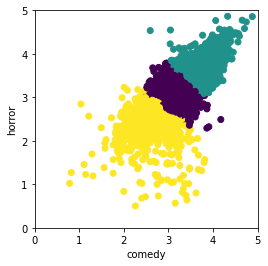

In [21]:
X = genre_ratings[['comedy','horror']].values

for x in [2,3]:
  kmeans = KMeans(n_clusters = x)

  prediction = kmeans.fit_predict(X)

  fig = plt.figure(figsize=(4,4))
  ax = fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('comedy')
  ax.set_ylabel('horror')

  clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':prediction})], axis=1)

  ax.scatter(genre_ratings['comedy'], genre_ratings['horror'], c=clustered['group'], cmap='viridis')

Use the knee method (also known as elbow method) to determine your ideal number of clusters.

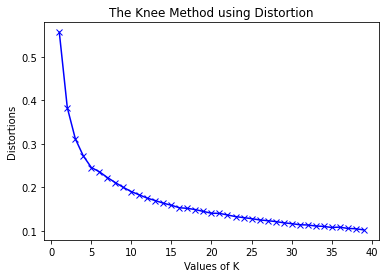

In [22]:
X = genre_ratings[['comedy','horror']].values

distortions = []
mapping = {}

K = range(1, 40)

for k in K:
  kmeans = KMeans(n_clusters = k)
  kmeans.fit_predict(X)

  distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0])
  mapping[k] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortions')
plt.title('The Knee Method using Distortion')
plt.show()

Create a new k-means clustering of the reviewers **mean** ratings between two seperate genres using the Knee Method.

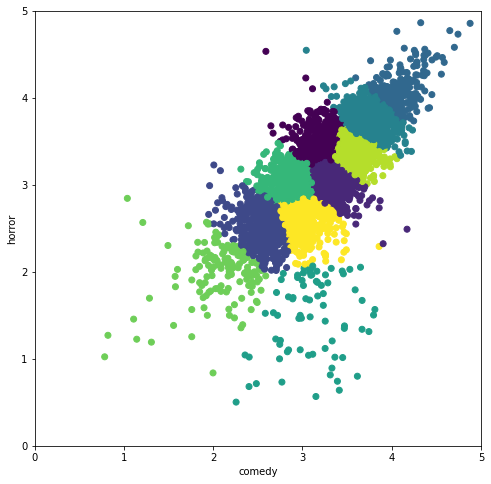

In [23]:
X = genre_ratings[['comedy','horror']].values

for x in [10]:
  kmeans = KMeans(n_clusters= x)

  prediction = kmeans.fit_predict(X)

  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('comedy')
  ax.set_ylabel('horror')

  clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':prediction})], axis=1)

  ax.scatter(genre_ratings['comedy'], genre_ratings['horror'], c=clustered['group'], cmap='viridis')

**Analysis: Imagine that you are a Netflix-type service, and want to help your users find movies they like better. How would you use your clustering results to serve this purpose, or improve your business in general?**

*Reminders: The data set has been filtered to show users who have reviewed at least 50 movies in both genres. 

**Insights:** Based on the clustering results of our dataset, it seems to suggest that people who like to watch either horror or comedy will also enjoy watching the other genre. Perhaps people who enjoy these genres like to experience a wide variety of emotions when they watch movies. However, there is one cluster of users who enjoy comedy but dislike horror. On the other hand, there is no similar cluster of horror fans disliking comedy movies.

**Suggestion:** Due to the fact that there are a finite amount of movies in each particular genre, our analysis suggest that we should recommend new genres to viewers that like comedy or horror movies.